In [ ]:
import kagglehub
uldisvalainis_audio_emotions_path = kagglehub.dataset_download('uldisvalainis/audio-emotions')

print('Data source import complete.')

100%|██████████| 1.12G/1.12G [00:53<00:00, 22.4MB/s]


Extracting files...
Data source import complete.


In [ ]:
import os
import librosa
import torchaudio
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import random
import librosa
import numpy as np
import torchaudio

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_name = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name).to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout)

In [ ]:
DATASET_PATH = "/root/.cache/kagglehub/datasets/uldisvalainis/audio-emotions/versions/1/Emotions"
OUTPUT_CSV = "wav2vec2_features.csv"

In [ ]:
def add_noise(audio, sr, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    audio = audio + noise_factor * noise
    return audio

def time_stretch(audio, sr, rate=1.2):
    return librosa.effects.time_stretch(y=audio, rate=rate)

def pitch_shift(audio, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)

def shift_audio(audio, sr, shift_max=0.2):
    shift = np.random.randint(int(sr * -shift_max), int(sr * shift_max))
    return np.roll(audio, shift)

def speed_change(audio, sr, speed_factor=1.2):
    audio_length = len(audio) / sr
    new_length = int(audio_length / speed_factor)
    audio = librosa.effects.time_stretch(y=audio, rate=speed_factor)
    audio = librosa.util.fix_length(audio, size=new_length * sr)
    return audio
def amplitude_scaling(audio, sr, scale_factor=1.5):
    return audio * scale_factor

In [ ]:
embedding_size = 512
feature_columns = [f"emb_{i}" for i in range(embedding_size)]
final_df = pd.DataFrame(columns=feature_columns + ["label", "filename"])

In [ ]:
def extract_wav2vec2_features(filepath, fonction_augmentation=None):
    speech_array, sampling_rate = torchaudio.load(filepath)
    speech_array = speech_array.squeeze().numpy()

    # Apply augmentation if provided
    if fonction_augmentation:
        speech_array = fonction_augmentation(speech_array, sampling_rate)

    # Resample to 16kHz if needed
    if sampling_rate != 16000:
        speech_array = librosa.resample(speech_array, orig_sr=sampling_rate, target_sr=16000)

    # Use processor to extract the embeddings
    inputs = processor(speech_array, sampling_rate=16000, return_tensors="pt", padding=True)
    input_values = inputs.input_values.to(device)
    attention_mask = inputs.attention_mask.to(device)

    with torch.no_grad():
        output = model(input_values, attention_mask=attention_mask)

    # Average pooling across time dimension to get final feature vector
    embeddings = output.extract_features.squeeze(0).cpu().numpy()
    mean_embedding = np.mean(embeddings, axis=0)
    return mean_embedding



In [ ]:
features = extract_wav2vec2_features('/root/.cache/kagglehub/datasets/uldisvalainis/audio-emotions/versions/1/Emotions/Angry/1080_IWL_ANG_XX.wav',shift_audio)
print(list(features))

[np.float32(0.2606937), np.float32(-0.62123775), np.float32(-0.72796345), np.float32(0.4850253), np.float32(0.0344004), np.float32(0.44209245), np.float32(-0.3186179), np.float32(-0.093668014), np.float32(1.5343022), np.float32(0.13682121), np.float32(0.61111474), np.float32(-0.22423396), np.float32(0.19342035), np.float32(-0.52671075), np.float32(-0.16632552), np.float32(0.39917925), np.float32(-0.20932537), np.float32(0.31433287), np.float32(-0.78242433), np.float32(0.9633741), np.float32(0.0054655387), np.float32(0.011661059), np.float32(0.40184292), np.float32(0.31615955), np.float32(-0.317172), np.float32(-0.6459265), np.float32(-0.068198085), np.float32(-0.33861193), np.float32(-0.5802085), np.float32(-0.6743748), np.float32(0.48854396), np.float32(0.030206572), np.float32(1.2069802), np.float32(-0.1947016), np.float32(-0.47674012), np.float32(0.3838012), np.float32(0.30661106), np.float32(-0.18721026), np.float32(0.30414915), np.float32(0.7314877), np.float32(-0.096754), np.floa

In [ ]:
import random
import os
from tqdm import tqdm
import pandas as pd
augmentation_methods = [add_noise, time_stretch, pitch_shift, shift_audio, speed_change, amplitude_scaling]
def process_audio_files(label, final_df, imbalance_factor=2):
    """
    Process audio files, apply augmentation, and store extracted features in final_df.

    Args:
        label (str): The label (emotion) of the current audio files.
        augmentation_methods (list): List of augmentation methods to choose from.
        final_df (pandas.DataFrame): DataFrame where the features will be stored.
        imbalance_factor (int, optional): Factor to increase the number of augmentations for underrepresented classes. Default is 2.

    """
    label_path = os.path.join(DATASET_PATH, label)

    # Count the current class size
    current_class_size = len(os.listdir(label_path))
    imbalance_factor = 1500//current_class_size + 1

    # Loop through all audio files in the label folder
    for file in tqdm(os.listdir(label_path), desc=f"Processing {label_path.split('/')[-1]} audio"):
        if file.endswith(".wav"):
            filepath = os.path.join(label_path, file)
            try:

                # Apply the augmentation method the appropriate number of times
                selected_augmentations = random.sample(augmentation_methods, imbalance_factor)

                # To address class imbalance, apply augmentations more often for underrepresented classes
                for augmentation_fn in selected_augmentations:  # Adjust the number of augmentations
                    augmentation_fn = random.choice(augmentation_methods)
                    features = extract_wav2vec2_features(filepath, augmentation_fn)
                    row = list(features) + [label, file]
                    final_df.loc[len(final_df)] = row

                # For the original audio (without augmentation), also extract features
                features = extract_wav2vec2_features(filepath, None)  # None means no augmentation
                row = list(features) + [label, file]
                final_df.loc[len(final_df)] = row

            except Exception as e:
                print(f"Error processing {filepath}: {e}")


In [ ]:
process_audio_files('Sad', final_df)

Processing Sad audio: 100%|██████████| 2167/2167 [07:08<00:00,  5.05it/s]


In [ ]:
process_audio_files('Angry', final_df)

Processing Angry audio: 100%|██████████| 2167/2167 [07:23<00:00,  4.89it/s]


In [ ]:
process_audio_files('Happy', final_df)

Processing Happy audio:   8%|▊         | 163/2167 [00:32<05:41,  5.87it/s]

Error processing /root/.cache/kagglehub/datasets/uldisvalainis/audio-emotions/versions/1/Emotions/Happy/03-01-03-01-02-01-20.wav: cannot set a row with mismatched columns


Processing Happy audio: 100%|██████████| 2167/2167 [07:09<00:00,  5.05it/s]


In [ ]:
process_audio_files('Neutral', final_df)

Processing Neutral audio:  78%|███████▊  | 1395/1795 [04:39<01:01,  6.55it/s]

Error processing /root/.cache/kagglehub/datasets/uldisvalainis/audio-emotions/versions/1/Emotions/Neutral/03-02-01-01-01-01-24.wav: cannot set a row with mismatched columns


Processing Neutral audio: 100%|██████████| 1795/1795 [05:59<00:00,  4.99it/s]


In [ ]:
process_audio_files('Fearful', final_df)

Processing Fearful audio:  38%|███▊      | 785/2047 [02:39<03:19,  6.33it/s]

Error processing /root/.cache/kagglehub/datasets/uldisvalainis/audio-emotions/versions/1/Emotions/Fearful/03-01-06-01-01-02-20.wav: cannot set a row with mismatched columns


Processing Fearful audio: 100%|██████████| 2047/2047 [06:58<00:00,  4.89it/s]


In [ ]:
process_audio_files('Disgusted', final_df)

Processing Disgusted audio: 100%|██████████| 1863/1863 [06:39<00:00,  4.67it/s]


In [ ]:
process_audio_files('Suprised', final_df)

Processing Suprised audio:   5%|▌         | 30/592 [00:13<04:22,  2.14it/s]

Error processing /root/.cache/kagglehub/datasets/uldisvalainis/audio-emotions/versions/1/Emotions/Suprised/03-01-08-01-02-02-01.wav: operands could not be broadcast together with shapes (2,156956) (2,) 


Processing Suprised audio: 100%|██████████| 592/592 [04:36<00:00,  2.14it/s]


In [ ]:
print(final_df.head())
print(final_df.shape)
print(final_df.info())

      emb_0     emb_1     emb_2     emb_3     emb_4     emb_5     emb_6  \
0 -0.019871 -0.489701 -0.485183  0.572018  0.091871  0.124721 -0.802416   
1  0.143948 -0.577538 -0.386115  0.575144  0.163283  0.079635 -0.753684   
2 -0.091103 -0.404202 -0.446372  0.414922  0.199972  0.224317 -0.293779   
3 -0.010729 -0.349528 -0.218807  0.234021  0.394668  0.215732 -0.188167   
4  0.019155 -0.295603 -0.801150  0.114177  0.083787  0.139823 -0.703317   

      emb_7     emb_8     emb_9  ...   emb_504   emb_505   emb_506   emb_507  \
0 -0.537673 -0.982134  2.518576  ...  6.242934  0.597229  0.964443 -0.937575   
1 -0.283638 -0.879207  2.528324  ...  5.565686  0.086005  0.937819 -0.907691   
2 -0.728123 -0.632390 -0.233443  ...  1.308085 -0.417241  0.272873 -0.524746   
3 -0.560032 -0.758080 -0.310106  ...  0.557640 -0.446366  0.395144 -0.723342   
4 -0.077439  0.405997  0.917695  ...  1.636819  0.779013  0.588947 -0.487659   

    emb_508   emb_509   emb_510   emb_511  label                  fi

In [ ]:
final_df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ Feature extraction complete. Saved to {OUTPUT_CSV}")


✅ Feature extraction complete. Saved to wav2vec2_features.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = pd.read_csv("/content/wav2vec2_features (1).csv")

# 2. Prepare features and labels
X = df.iloc[:, :-2].values  # All embedding columns
y = df["label"].values

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Reshape to 2D array for OneHotEncoder
y = y.reshape(-1, 1) if isinstance(y, np.ndarray) else np.array(y).reshape(-1, 1)

# Initialize encoder
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = onehot_encoder.fit_transform(y)

# Store class labels
class_labels = onehot_encoder.categories_[0]

In [ ]:
print(class_labels)

['Angry' 'Disgusted' 'Fearful' 'Happy' 'Neutral' 'Sad' 'Suprised']


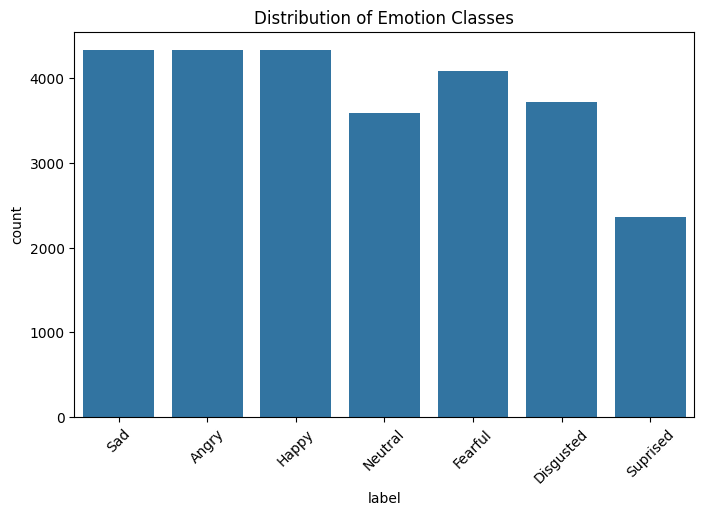

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='label')
plt.title("Distribution of Emotion Classes")
plt.xticks(rotation=45)
plt.show()



In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.3, random_state=1, stratify=y_onehot)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18739, 512), (8031, 512), (18739, 7), (8031, 7))

In [ ]:
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,927 (1.08 MB)

 Trainable params: 281,927 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8478 - loss: 0.4269 - val_accuracy: 0.7929 - val_loss: 0.6212
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8608 - loss: 0.4028 - val_accuracy: 0.7919 - val_loss: 0.6111
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8572 - loss: 0.4149 - val_accuracy: 0.7927 - val_loss: 0.6185
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8622 - loss: 0.4108 - val_accuracy: 0.7903 - val_loss: 0.6069
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8528 - loss: 0.4266 - val_accuracy: 0.7919 - val_loss: 0.6186
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8528 - loss: 0.4186 - val_accuracy: 0.7856 - val_loss: 0.6476
Epoch 7/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8628 - loss: 0.4045 - val_accuracy: 0.7898 - val_loss: 0.6439
Epoch 8/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8602 - loss: 0.4119 - val_accuracy: 0.

In [ ]:
model.save('emotion_model_final.h5')

In [ ]:
model.save('emotion_model_final.keras')

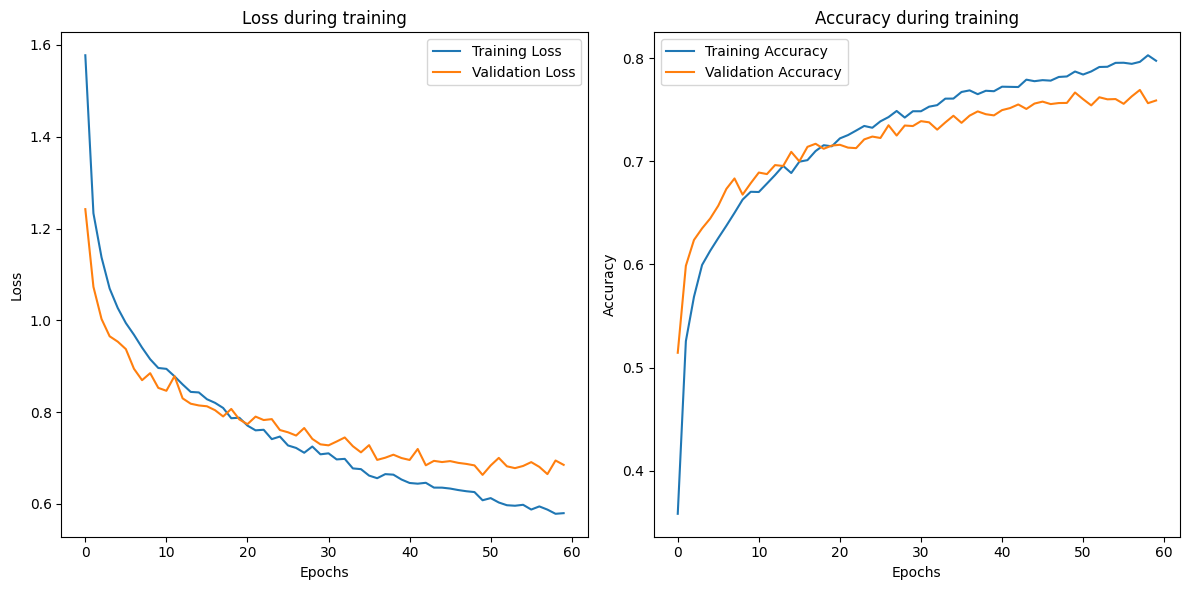

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Visualizing the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report

# After prediction
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))



251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

       Angry       0.90      0.83      0.86      1300
   Disgusted       0.62      0.70      0.66      1118
     Fearful       0.78      0.64      0.70      1228
       Happy       0.78      0.73      0.75      1300
     Neutral       0.67      0.84      0.74      1076
         Sad       0.74      0.69      0.72      1300
    Suprised       0.87      0.98      0.92       709

    accuracy                           0.76      8031
   macro avg       0.77      0.77      0.77      8031
weighted avg       0.77      0.76      0.76      8031



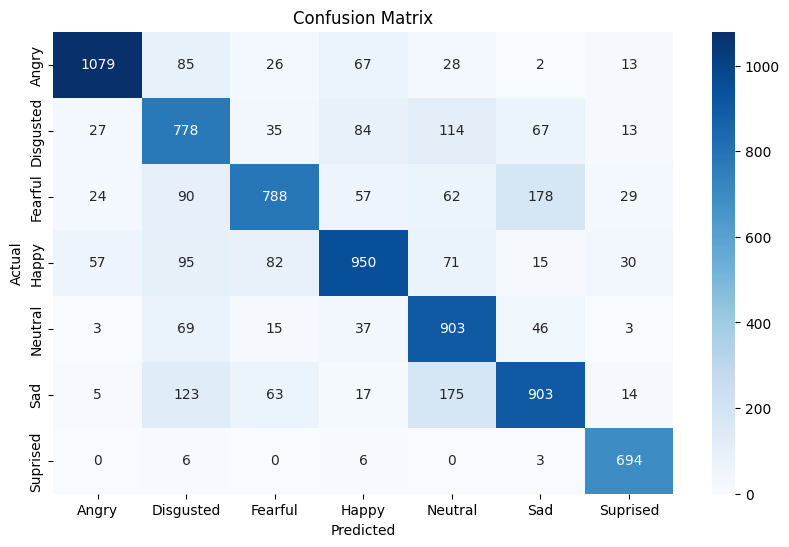

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
import numpy as np

# Reshape for Conv1D (add channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
X_train_cnn.shape, X_test_cnn.shape

((18739, 512, 1), (8031, 512, 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

def build_cnn_model(input_shape, num_classes):
    model = Sequential()

    # Block 1
    model.add(Conv1D(256, kernel_size=5, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(256, kernel_size=5, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Block 2
    model.add(Conv1D(128, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(128, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Block 3
    model.add(Conv1D(64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))

    # Fully Connected
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))


    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
input_shape = (X_train_cnn.shape[1], 1)
num_classes = y_train.shape[1]

model = build_cnn_model(input_shape, num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=100,
    batch_size=64
)

Epoch 1/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.1987 - loss: 1.9063 - val_accuracy: 0.2239 - val_loss: 1.8042
Epoch 2/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.3988 - loss: 1.4936 - val_accuracy: 0.5297 - val_loss: 1.1840
Epoch 3/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.5042 - loss: 1.2637 - val_accuracy: 0.5555 - val_loss: 1.1103
Epoch 4/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5406 - loss: 1.1674 - val_accuracy: 0.6002 - val_loss: 1.0324
Epoch 5/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.5693 - loss: 1.1120 - val_accuracy: 0.6298 - val_loss: 0.9699
Epoch 6/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.5888 - loss: 1.0651 - val_accuracy: 0.6431 - val_loss: 0.9424
Epoch 7/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.6088 - loss: 1.0192 - val_accuracy: 0.6364 - val_loss: 0.9332
Epoch 8/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6180 - loss: 1

In [ ]:
history2 = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=10,
    batch_size=64
)

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8552 - loss: 0.3946 - val_accuracy: 0.7822 - val_loss: 0.6434
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8569 - loss: 0.3932 - val_accuracy: 0.7785 - val_loss: 0.6394
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8583 - loss: 0.3942 - val_accuracy: 0.7832 - val_loss: 0.6272
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8614 - loss: 0.3845 - val_accuracy: 0.7810 - val_loss: 0.6285
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8537 - loss: 0.3823 - val_accuracy: 0.7832 - val_loss: 0.6242
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8609 - loss: 0.3787 - val_accuracy: 0.7805 - val_loss: 0.6288
Epoch 7/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8585 - loss: 0.3800 - val_accuracy: 0.7867 - val_loss: 0.6360
Epoch 8/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8627 - loss: 0.3793 - 

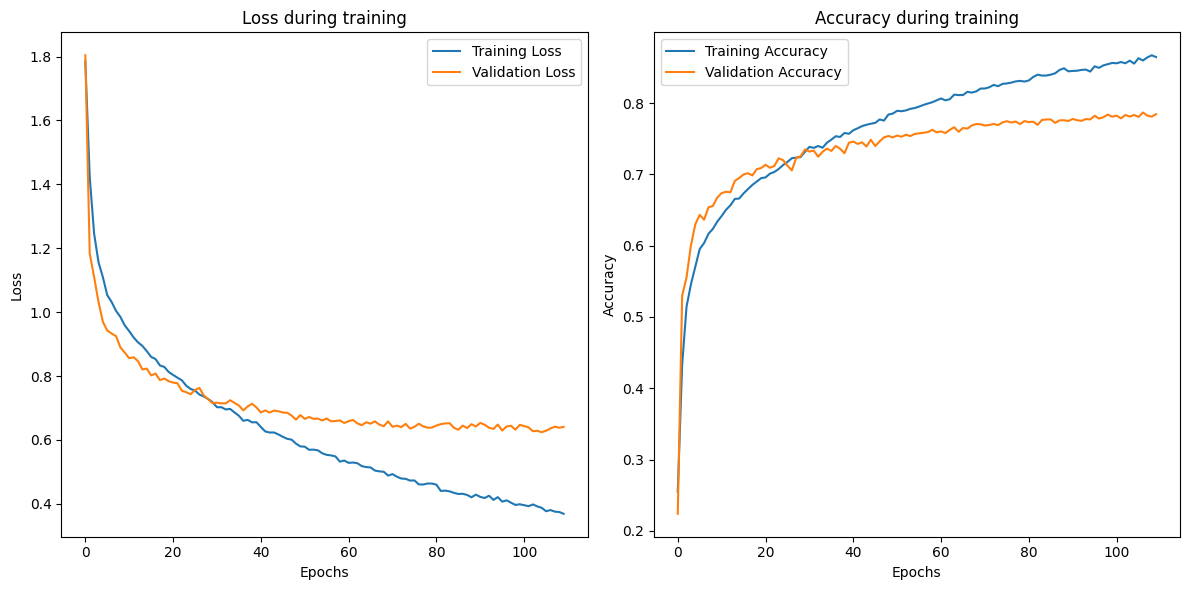

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss']+history2.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss']+history2.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Visualizing the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy']+history2.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy']+history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict
y_pred = model.predict(X_test_cnn)


251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7835 - loss: 0.6399
Test Accuracy: 0.78
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


              precision    recall  f1-score   support

       Angry       0.88      0.83      0.85      1300
   Disgusted       0.68      0.71      0.69      1118
     Fearful       0.77      0.74      0.75      1228
       Happy       0.74      0.78      0.76      1300
     Neutral       0.76      0.77      0.77      1076
         Sad       0.79      0.76      0.77      1300
    Suprised       0.93      0.97      0.95       709

    accuracy                           0.78      8031
   macro avg       0.79      0.79      0.79      8031
weighted avg       0.79      0.78      0.78      8031



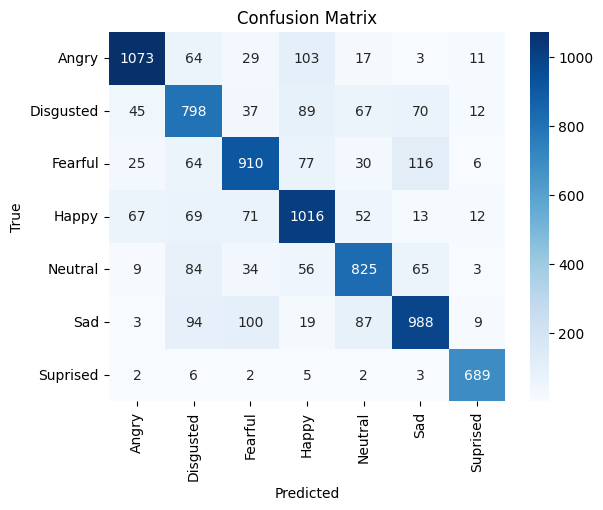

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
